In [6]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    sum_ = tf.keras.backend.sum(tf.keras.backend.abs(y_true) + tf.keras.backend.abs(y_pred), axis=[1,2,3])
    iou = (intersection + smooth) / (sum_ - intersection + smooth)
    return tf.keras.backend.mean(iou, axis=0)

def random_flip(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask

def random_rotate(image, mask):
    angles = tf.random.uniform(shape=[], minval=-np.pi/4, maxval=np.pi/4)
    image = tfa.image.rotate(image, angles)
    mask = tfa.image.rotate(mask, angles)
    return image, mask

def random_zoom(image, mask, zoom_range=(0.8, 1.2)):
    scale = tf.random.uniform([], zoom_range[0], zoom_range[1])
    h, w, _ = image.shape
    new_h, new_w = tf.cast(scale * h, tf.int32), tf.cast(scale * w, tf.int32)
    image = tf.image.resize(image, [new_h, new_w])
    mask = tf.image.resize(mask, [new_h, new_w])

    image = tf.image.resize_with_crop_or_pad(image, h, w)
    mask = tf.image.resize_with_crop_or_pad(mask, h, w)
    return image, mask

def random_brightness(image, mask, max_delta=0.2):
    image = tf.image.random_brightness(image, max_delta)
    return image, mask

def data_augmentation(image, mask):
    image, mask = random_flip(image, mask)
    image, mask = random_rotate(image, mask)
    image, mask = random_zoom(image, mask)
    image, mask = random_brightness(image, mask)
    return image, mask

In [13]:
def unet_model(input_size=(128, 128, 3), num_classes=2):
    inputs = Input(input_size)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)


    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model


In [14]:
def load_data(image_dir, mask_dir, classes):
    images = []
    masks = []
    num_classes = len(classes)
    for filename in os.listdir(image_dir):
         if filename.lower().endswith(('.jpg', '.jpeg')):
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename)

            img = cv2.imread(image_path)
            mask = cv2.imread(mask_path, 0)           
            img = cv2.resize(img, (128, 128))
            mask = cv2.resize(mask, (128, 128))
            _, binary_mask = cv2.threshold(mask, 128, 1, cv2.THRESH_BINARY)

            images.append(img)
            masks.append(binary_mask)

    images = np.array(images, dtype="float32")
    masks = np.array(masks)
    masks = to_categorical(masks, num_classes=num_classes)
    return images, masks

In [17]:
classes = {
    "not_cloud": 0,
    "cloud": 1
}
image_path = './images/original'
mask_path = './images/mask'

images, masks = load_data(image_path, mask_path, classes)

train_size = 0.6
val_size = 0.15
test_size = 0.15

label_encoder = LabelEncoder()
labels = np.argmax(masks, axis=-1).flatten()
label_encoder.fit(labels)

X_train, X_, y_train, y_ = train_test_split(images, masks, train_size=train_size, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, random_state=42)
print(f"train: {len(X_train)} ({len(X_train)/len(masks):.5f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(masks):.5f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(masks):.5f})")

X_train = X_train/255
X_test = X_test/255
X_val = X_val/255
counts = {}
counts["train_counts"] = {tag: list(label_encoder.inverse_transform(np.argmax(y_train, axis=-1).flatten())).count(tag) for tag in label_encoder.classes_}
counts["val_counts"] = {tag: list(label_encoder.inverse_transform(np.argmax(y_val, axis=-1).flatten())).count(tag) for tag in label_encoder.classes_}
counts["test_counts"] = {tag: list(label_encoder.inverse_transform(np.argmax(y_test, axis=-1).flatten())).count(tag) for tag in label_encoder.classes_}
print("\nClass distribution in training set:", counts["train_counts"])
print("Class distribution in validation set:", counts["val_counts"])
print("Class distribution in test set:", counts["test_counts"])

# TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 16
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# model
input_size = (128, 128, 3)
num_classes = len(classes)
model = unet_model(input_size=input_size, num_classes=num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

epochs = 25
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
model.save("unet_model.h5")

train: 12 (0.60000)
remaining: 8 (0.40000)

train: 12 (0.60000)
val: 4 (0.20000)
test: 4 (0.20000)

Class distribution in training set: {0: 94595, 1: 102013}
Class distribution in validation set: {0: 38322, 1: 27214}
Class distribution in test set: {0: 38371, 1: 27165}
Epoch 1/25
1/1 [==============================] - 34s 34s/step - loss: 0.6947 - dice_coef: 0.4671 - val_loss: 0.6877 - val_dice_coef: 0.5073
Epoch 2/25
1/1 [==============================] - 30s 30s/step - loss: 0.6735 - dice_coef: 0.4684 - val_loss: 0.6931 - val_dice_coef: 0.5159
Epoch 3/25
1/1 [==============================] - 26s 26s/step - loss: 0.6611 - dice_coef: 0.5027 - val_loss: 0.7073 - val_dice_coef: 0.5229
Epoch 4/25
1/1 [==============================] - 28s 28s/step - loss: 0.6508 - dice_coef: 0.5282 - val_loss: 0.6974 - val_dice_coef: 0.5290
Epoch 5/25
1/1 [==============================] - 28s 28s/step - loss: 0.6600 - dice_coef: 0.5226 - val_loss: 0.6794 - val_dice_coef: 0.5350
Epoch 6/25
1/1 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step


Number of test images: 4
Number of test masks: 4
Shape of predictions: (4, 128, 128, 2)
Average Dice Coefficient: 0.8435440063476562


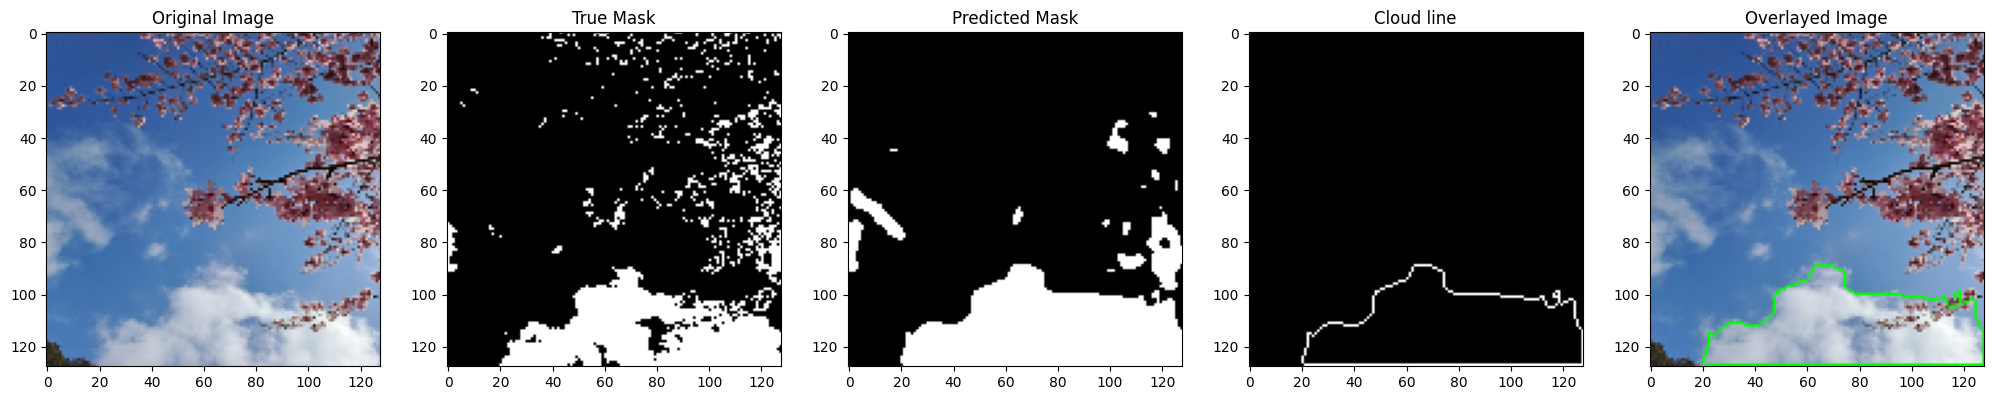

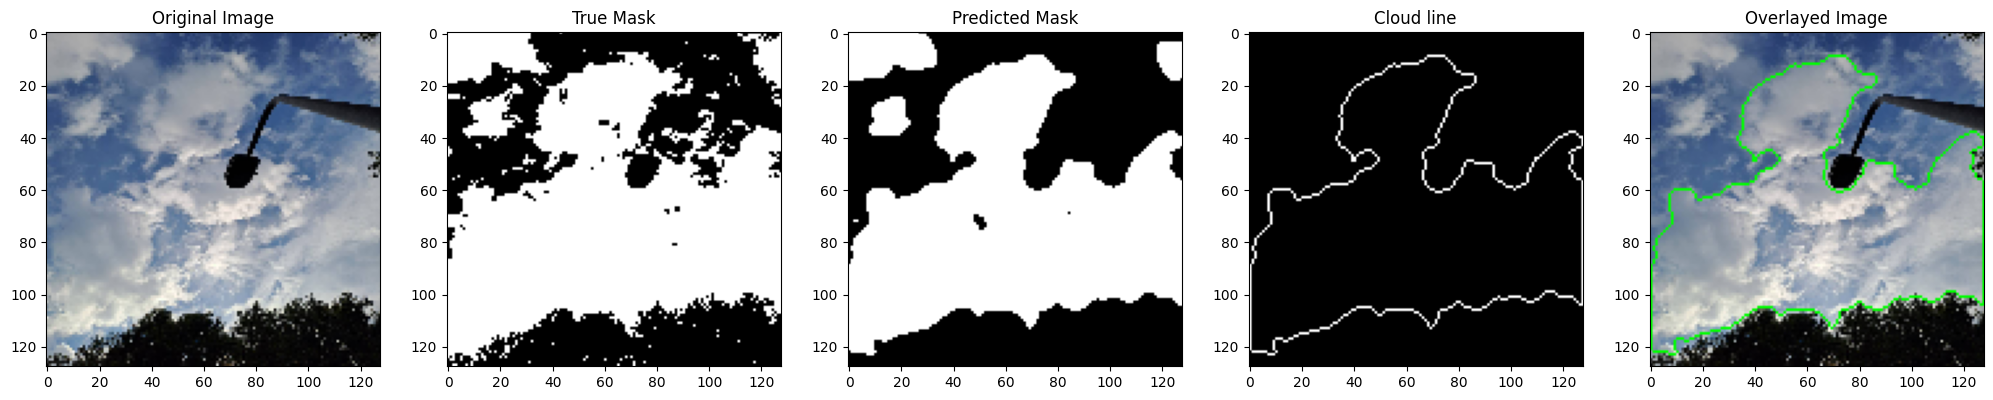

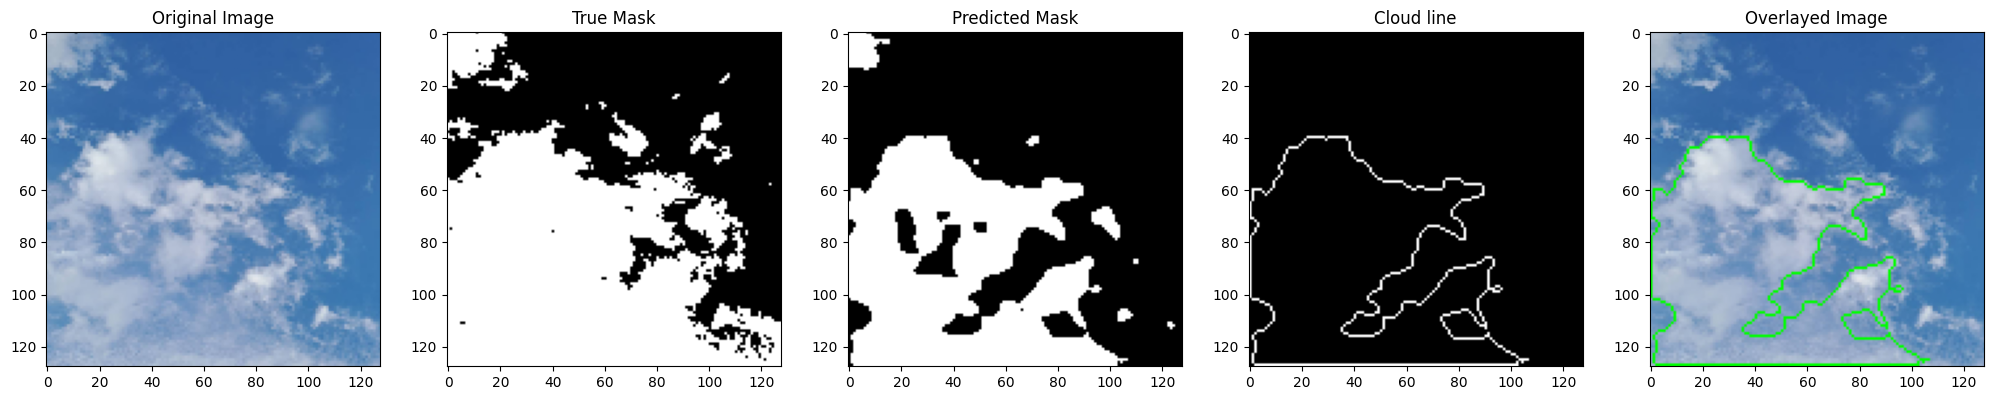

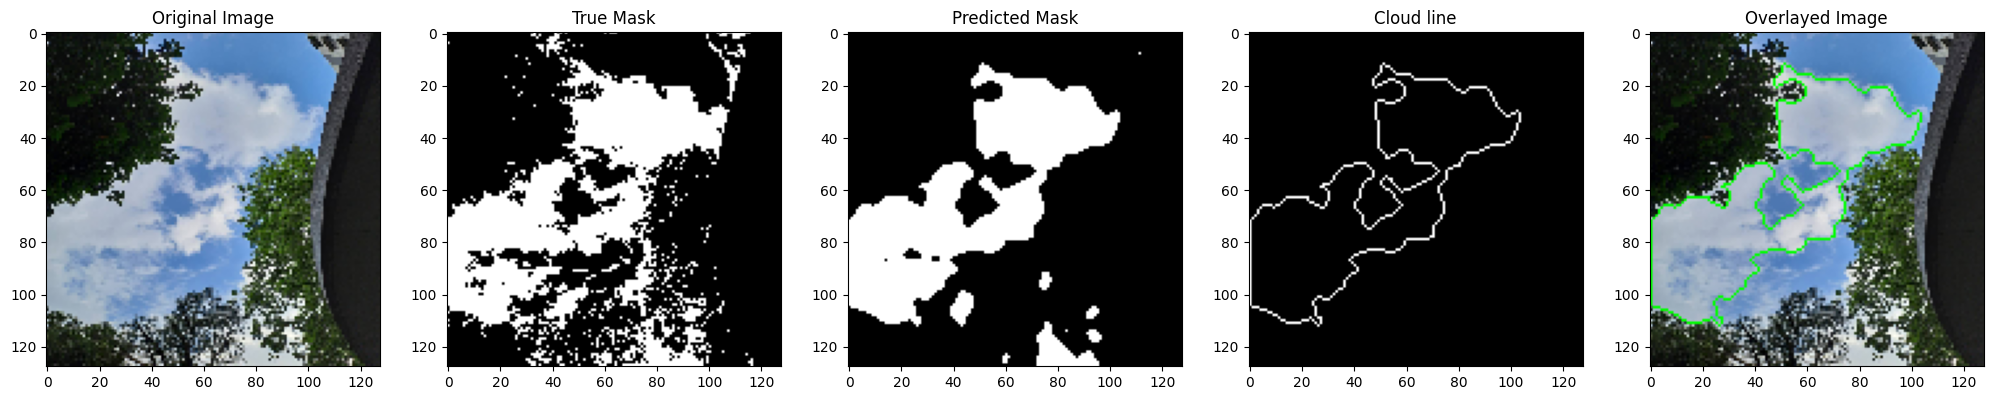

In [19]:
def detect_cloud(pred_masks, threshold=0.5):
    clouds = []
    contours_list = []
    for pred_mask in pred_masks:
        binary_mask = (pred_mask[:, :, 1] > threshold).astype(np.uint8) * 255
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        contours_list.append(largest_contour)

        cloud_image = np.zeros_like(binary_mask)
        cv2.drawContours(cloud_image, [largest_contour], -1, (255, 255, 255), 1)

        clouds.append(cloud_image)
    return clouds, contours_list

def overlay_cloud_on_image(images, contours_list):
    overlaid_images = []
    for image, contour in zip(images, contours_list):
        
        if isinstance(image, tf.Tensor):
            image = image.numpy().astype(np.uint8)
        
        overlay_image = image.copy()
        cv2.drawContours(overlay_image, [contour], -1, (0, 255, 0), 1)
        overlaid_images.append(overlay_image)
    return overlaid_images

def display_images_masks_cloud_overlays(images, true_masks, pred_masks, clouds, overlaid_images, num_images=10):
    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(25, 5))

        plt.subplot(1, 5, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

        plt.subplot(1, 5, 2)
        plt.title("True Mask")
        plt.imshow(np.argmax(true_masks[i], axis=-1), cmap='gray')

        plt.subplot(1, 5, 3)
        plt.title("Predicted Mask")
        plt.imshow(np.argmax(pred_masks[i], axis=-1), cmap='gray')

        plt.subplot(1, 5, 4)
        plt.title("Cloud line")
        plt.imshow(clouds[i], cmap='gray')

        plt.subplot(1, 5, 5)
        plt.title("Overlayed Image")
        plt.imshow(cv2.cvtColor(overlaid_images[i], cv2.COLOR_BGR2RGB))

        plt.show()

model = tf.keras.models.load_model("unet_model.h5", custom_objects={'dice_coef': dice_coef})
predictions = model.predict(test_dataset)

test_images = []
test_masks = []
for image, mask in test_dataset.unbatch().take(10):
    test_images.append(image.numpy())
    test_masks.append(mask.numpy())

test_images = np.array(test_images)
test_masks = np.array(test_masks)

print(f"Number of test images: {len(test_images)}")
print(f"Number of test masks: {len(test_masks)}")
print(f"Shape of predictions: {predictions.shape}")

dice_scores = []
for true_mask, pred_mask in zip(test_masks, predictions[:len(test_masks)]):
    dice = dice_coef(true_mask, pred_mask).numpy()
    dice_scores.append(dice)

average_dice = np.mean(dice_scores)
print(f"Average Dice Coefficient: {average_dice}")

clouds, contours_list = detect_cloud(predictions[:len(test_images)])
overlaid_images = overlay_cloud_on_image(test_images, contours_list)

display_images_masks_cloud_overlays(test_images, test_masks, predictions[:len(test_images)], clouds, overlaid_images)